<a href="https://colab.research.google.com/github/Yassmina-Abdo/deep-learning/blob/main/03_CIFAR_10_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import random

## Load data

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

## Insights

In [3]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [4]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


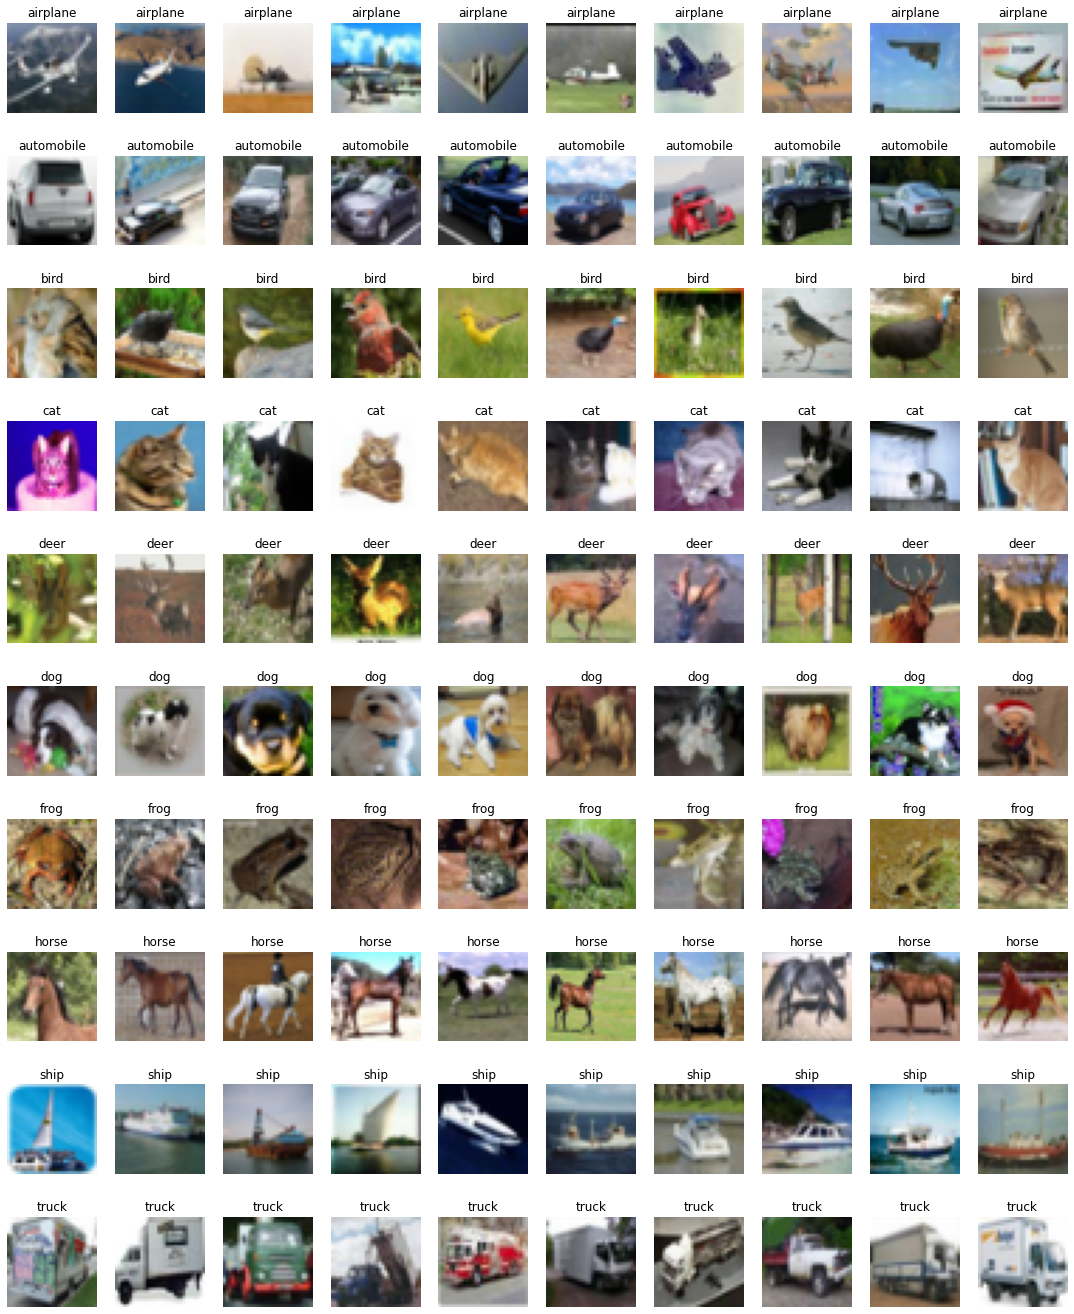

In [5]:
# SHOW IMAGE
cols = 10
rows = 10
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        index,_ = random.choice([(k, p) for k, row in enumerate(train_labels) for p, val in enumerate(row) if val == i])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(train_images[index, :])
        ax.set_title(cifar10_classes[i])
plt.show()

## Preprocessing

In [6]:
# One hot encoding for Y
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [7]:
# IMAGE AUGMENTATION
train_datagen = ImageDataGenerator(
                            rotation_range=0.5, 
                            zoom_range=0.2, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.5,
                            ) 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
train_generator = train_datagen.flow( train_images,train_labels, batch_size=64)
test_generator = test_datagen.flow(test_images,test_labels,batch_size=64 )     

In [9]:
train_generator.x.shape

(50000, 32, 32, 3)

## Model

In [10]:
from keras.layers import Input
from tensorflow.keras.applications import VGG19
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import keras
from tensorflow.keras import optimizers


In [11]:
inputs = Input(shape = (240, 240, 3), name = 'Image_input')
conv_base = VGG19(weights='imagenet', include_top=False, input_shape= (240,240,3))
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [12]:
# Freeze base model
conv_base.trainable = False

In [13]:
x = conv_base(inputs, training=False)

# Add the fully-connected layers
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) 
x = Dropout(0.1)(x) 
x = Dense(1024,activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) 
outputs = Dense(10, activation='softmax', name='predictions')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 240, 240, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                             

In [14]:
# compile CNN model
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),optimizer = optimizers.RMSprop(lr=2e-5) , metrics=[keras.metrics.CategoricalAccuracy()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [15]:
results_aug_with_TL = model.fit_generator(train_generator,validation_data = test_generator, epochs= 30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 35s 41ms/step - loss: 2.1330 - categorical_accuracy: 0.3161 - val_loss: 1.8193 - val_categorical_accuracy: 0.3489
Epoch 2/30
782/782 [==============================] - 33s 42ms/step - loss: 1.7377 - categorical_accuracy: 0.4179 - val_loss: 1.7172 - val_categorical_accuracy: 0.3919
Epoch 3/30
782/782 [==============================] - 32s 41ms/step - loss: 1.6217 - categorical_accuracy: 0.4500 - val_loss: 1.6620 - val_categorical_accuracy: 0.4100
Epoch 4/30
782/782 [==============================] - 30s 39ms/step - loss: 1.5568 - categorical_accuracy: 0.4703 - val_loss: 1.6246 - val_categorical_accuracy: 0.4245
Epoch 5/30
782/782 [==============================] - 30s 39ms/step - loss: 1.5073 - categorical_accuracy: 0.4843 - val_loss: 1.5992 - val_categorical_accuracy: 0.4304
Epoch 6/30
782/782 [==============================] - 30s 39ms/step - loss: 1.4700 - categorical_accuracy: 0.4950 - val_loss: 1.6003 - val_categorical_accuracy: 0.4353
Epo